In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score,accuracy_score, precision_score,recall_score, roc_curve, auc,classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from keras.datasets import cifar10

import warnings
warnings.filterwarnings('ignore')

c:\Miniconda\envs\cs178\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


60000 images total. We have 10,000 testing images and 50,000 images for training. We further split the 50,000 images into 40,000 images for training and 10,000 images for validation

In [2]:
(X_tr, y_tr), (X_te, y_te) = cifar10.load_data()
seed = 1234 # for reproduction
# Concatenate train and test images
X = np.concatenate((X_tr,X_te))
y = np.concatenate((y_tr,y_te))
# Randomization
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=10000, random_state=seed,shuffle=True)
# size of X_tr = (50000,32,32,3) where (32,32) is size of the image and (3) is red,green,and blue channel values.
# we have 50000 datapoints for training set, and each set will have 32*32*3 = 3072 features. we need to reshape for training 
X_tr = X_tr.reshape(50000,3072)
X_te = X_te.reshape(10000,3072)
y_tr = y_tr.reshape(50000)
y_te = y_te.reshape(10000)

#X_tr_lc is training set with 50000 datapoints for model.selection.learning_curve
X_tr_lc = X_tr
y_tr_lc = y_tr


In [3]:
# Validation sets
X_val = X_tr[40000:50000]
y_val = y_tr[40000:50000]
# Training sets
X_tr = X_tr[:40000]
y_tr = y_tr[:40000]
print(X_tr.shape)
print(y_tr.shape)

(40000, 3072)
(40000,)


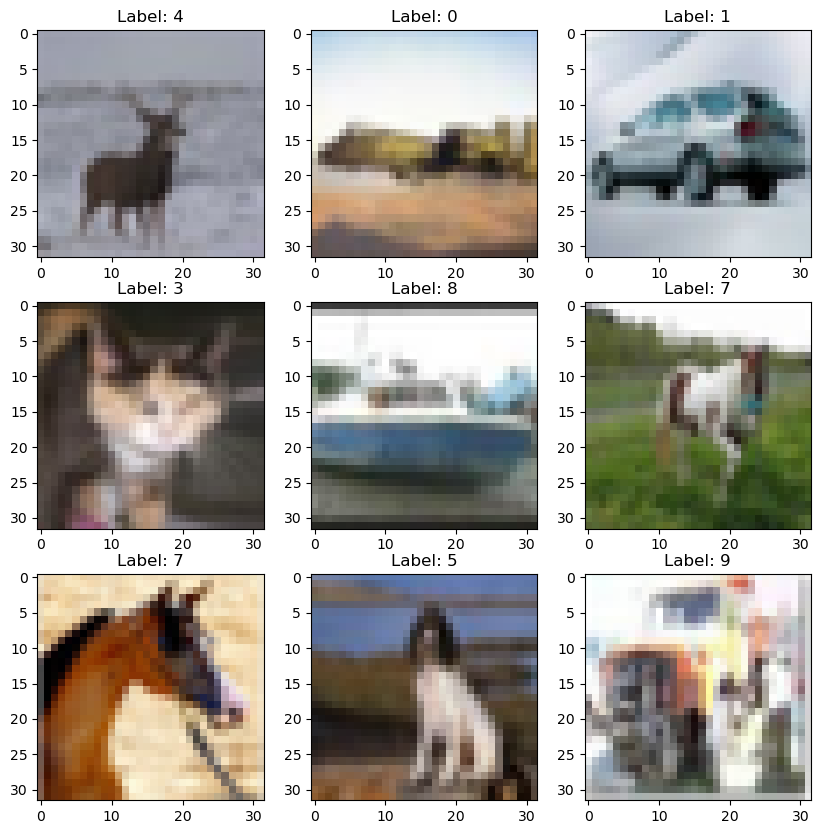

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 

for i in range(9):
    img = X_tr[i]
    axes[i//3, i%3].imshow(img.reshape(32,32,3)) # to show the image, we have to convert 3072 features back to (32,32,3)
    label = y_tr[i] 
    axes[i//3, i%3].set_title(f'Label: {label}') 

In [4]:
# Reshape fit and transform the data for better results
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)
X_val = scaler.transform(X_val)
X_tr_lc = scaler.transform(X_tr_lc)
#Take smaller size of training set for better runtime
#X_tr = X_tr[:5000]
#y_tr = y_tr[:5000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


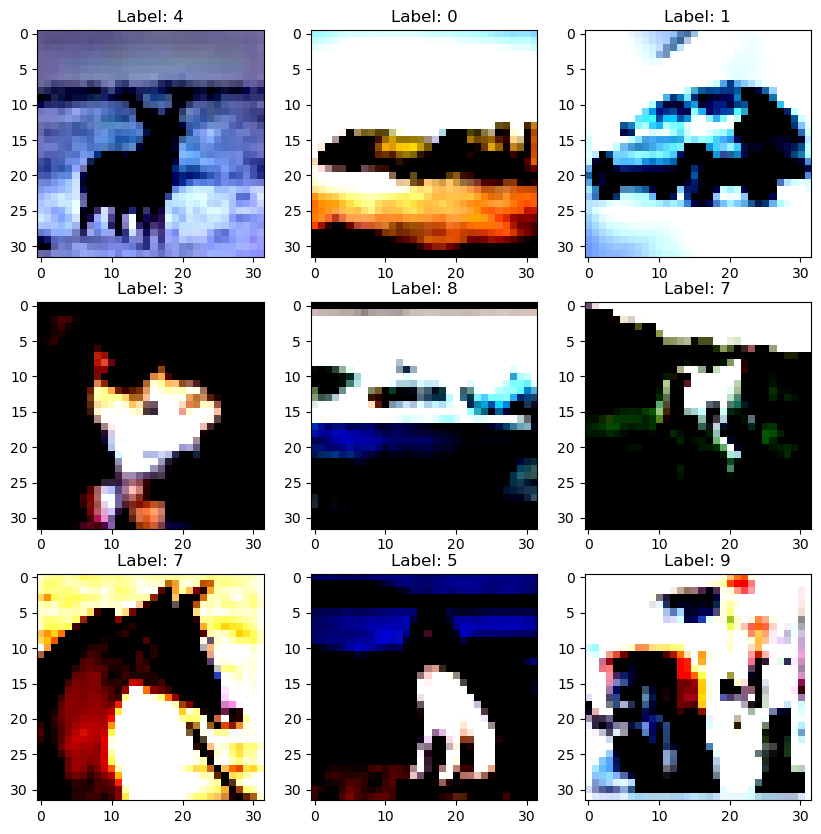

In [6]:
#plot scaled images
fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 

for i in range(9):
    img = X_tr[i]
    axes[i//3, i%3].imshow(img.reshape(32,32,3)) # to show the image, we have to convert 3072 features back to (32,32,3)
    label = y_tr[i] 
    axes[i//3, i%3].set_title(f'Label: {label}') 

1. KNN Classifier

In [32]:
#KNN
val_error_list = []
te_error_list = []
tr_error_list = []
max_accuracy_index = 0
max_accuracy = 0
best_k_test_accuracy = 0
i = 0
#different hyper parameters
k_list = [3,5,7,9,11,13,15,25,50,100,250,500,750,1000,1250,1500,2000,2500,3000]
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_tr, y_tr)
    # Accuracy/error
    val_accuracy = knn.score(X_val,y_val)
    val_error = 1 - val_accuracy
    te_accuracy = knn.score(X_te,y_te)
    te_error = 1-te_accuracy
    tr_accuracy = knn.score(X_tr,y_tr)
    tr_error = 1-tr_accuracy

    val_error_list.append(val_error)
    te_error_list.append(te_error)
    tr_error_list.append(tr_error)
    #determine the best k's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_k_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_k_test_accuracy = te_accuracy
    i+=1
#end for

best_k = k_list[max_accuracy_index]
print("best k is:", best_k,"accuracy on testing set is ", best_k_test_accuracy)
#best k is: 7 accuracy on testing set is  0.3326

best k is: 7 accuracy on testing set is  0.3326


In [24]:
# plot graphs for best_k
knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_tr, y_tr)

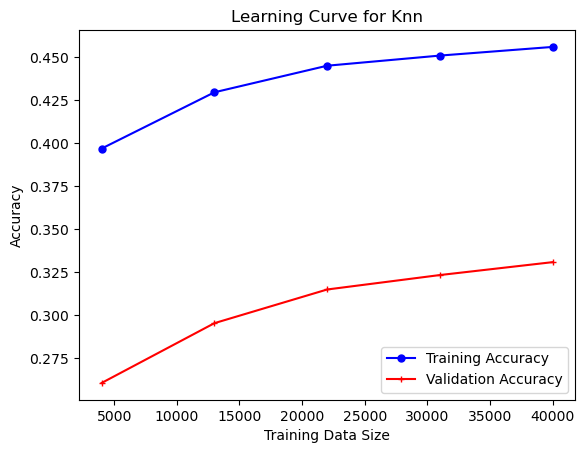

In [9]:
fig, axes = plt.subplots()
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=knn, X=X_tr_lc, y=y_tr_lc,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for Knn')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')

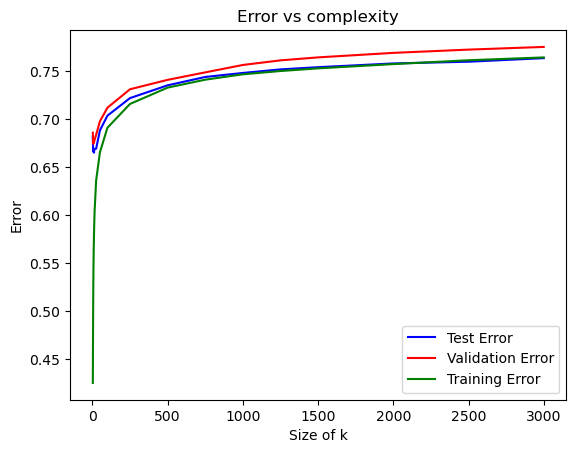

In [33]:
fig, axes = plt.subplots()
#Error vs complexity tradeoffs
axes.plot(k_list, te_error_list, color='blue',  label='Test Error')
axes.plot(k_list, val_error_list, color='red',  label='Validation Error')
axes.plot(k_list, tr_error_list, color='green',  label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Size of k')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

In [21]:
#roc_auc_scores for testing set and classfication report
y_te_scores = knn.predict_proba(X_te)
print('Testing set roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))
print(classification_report(y_te, knn.predict(X_te)))

Testing set roc_auc_score: 0.74307
              precision    recall  f1-score   support

           0       0.40      0.54      0.46       986
           1       0.74      0.18      0.29      1018
           2       0.23      0.43      0.30      1005
           3       0.31      0.24      0.27      1023
           4       0.22      0.51      0.30      1004
           5       0.46      0.21      0.28      1024
           6       0.34      0.26      0.29      1006
           7       0.68      0.19      0.30       951
           8       0.38      0.68      0.49       992
           9       0.70      0.09      0.17       991

    accuracy                           0.33     10000
   macro avg       0.45      0.33      0.32     10000
weighted avg       0.45      0.33      0.32     10000



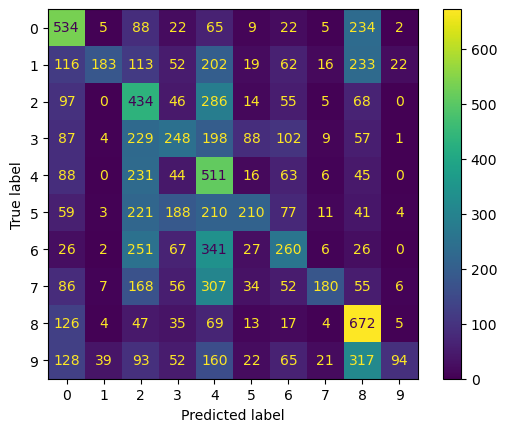

In [22]:
#Confusion Matrix for the best k
y_te_pred = knn.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

In [26]:
#Prediction speed knn
knn.predict(X_tr)
#40000 datapoints takes 145.3s = 145300ms
#speed = 3.6325ms/datapoint


array([2, 0, 8, ..., 2, 2, 2], dtype=uint8)

2.Logistic Regression

In [91]:
# GRIDSEARCH FOR LOGISTIC
X_tr1 = X_tr[:5000]
y_tr1 = y_tr[:5000]
#Using GridSearch to find the best hyperparameters for logistic regression classifer
model = LogisticRegression(random_state=seed)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
parameters = dict()
# parameters['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
parameters['penalty'] = ['none','l2']
parameters['C'] = [100, 10, 1.0, 0.1, 0.01]

search = GridSearchCV(model, parameters, scoring='accuracy', n_jobs=2, cv=10)
search = search.fit(X_tr1,y_tr1)

print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)


Best Score: 0.3324
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}


In [5]:
#logistic regression
val_error_list = []
te_error_list = []
tr_error_list = []
max_accuracy_index = 0
max_accuracy = 0
best_C_test_accuracy = 0
i = 0
#different hyper parameters
C_list = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]
for c in C_list:
    lr = LogisticRegression(penalty = 'l2',C= c,random_state=seed).fit(X_tr,y_tr)
    # Accuracy/error
    val_accuracy = lr.score(X_val,y_val)
    val_error = 1 - val_accuracy
    te_accuracy = lr.score(X_te,y_te)
    te_error = 1-te_accuracy
    tr_accuracy = lr.score(X_tr,y_tr)
    tr_error = 1-tr_accuracy

    val_error_list.append(val_error)
    te_error_list.append(te_error)
    tr_error_list.append(tr_error)
    #determine the best C's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_C_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_C_test_accuracy = te_accuracy
    i+=1
#end for

best_C= C_list[max_accuracy_index]
print("best C is:", best_C,"accuracy on testing set is ", best_C_test_accuracy)
# best C is: 0.0005 accuracy on testing set is  0.412

best C is: 0.0005 accuracy on testing set is  0.412


In [28]:
lr = LogisticRegression(penalty = 'l2',C= best_C,random_state=seed).fit(X_tr,y_tr)

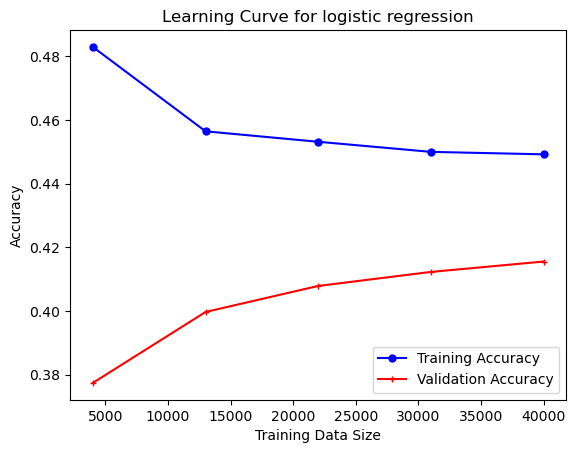

In [7]:
fig, axes = plt.subplots()
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X_tr_lc, y=y_tr_lc,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for logistic regression')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')

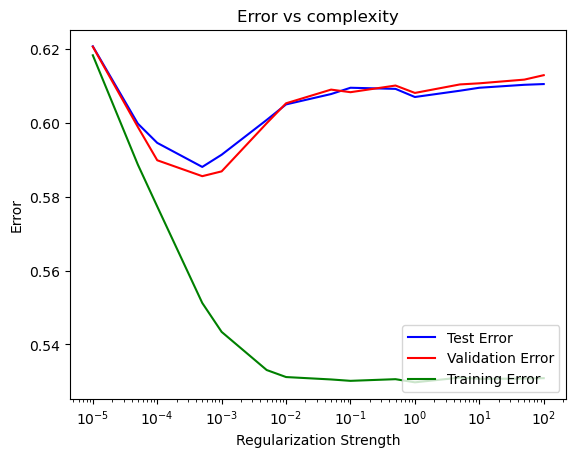

In [8]:
fig, axes = plt.subplots()
#Error vs complexity tradeoffs
axes.semilogx(C_list, te_error_list, color='blue',  label='Test Error')
axes.semilogx(C_list, val_error_list, color='red',  label='Validation Error')
axes.semilogx(C_list, tr_error_list, color='green',  label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Regularization Strength')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

In [9]:
#roc_auc_scores for testing set and classfication report
y_te_scores = lr.predict_proba(X_te)
print('Testing set roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))
print(classification_report(y_te, lr.predict(X_te)))

Testing set roc_auc_score: 0.82014
              precision    recall  f1-score   support

           0       0.46      0.51      0.48       986
           1       0.47      0.51      0.49      1018
           2       0.32      0.26      0.29      1005
           3       0.30      0.28      0.29      1023
           4       0.37      0.31      0.33      1004
           5       0.36      0.32      0.34      1024
           6       0.40      0.47      0.43      1006
           7       0.45      0.44      0.44       951
           8       0.51      0.55      0.53       992
           9       0.44      0.49      0.46       991

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000



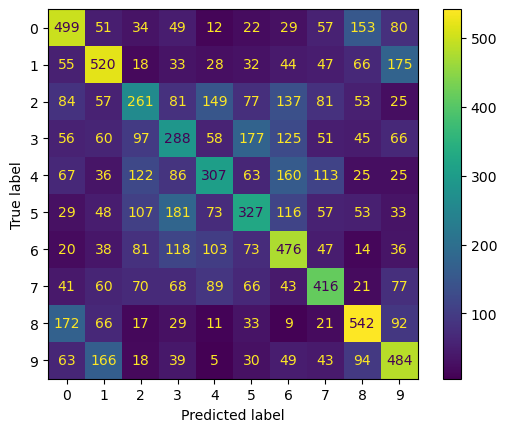

In [10]:
#Confusion Matrix
y_te_pred = lr.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

In [29]:
#Prediction speed logistic regression
lr.predict(X_tr)
#40000 datapoints takes 0.4s = 400ms
#speed = 0.01ms/datapoint

array([0, 0, 0, ..., 7, 4, 1], dtype=uint8)

3.Neural Network

In [ ]:
# param = [
#     {'scaler': [StandardScaler()],
#      'estimator': [MLPClassifier(random_state=seed)],
#      'estimator__solver': ['adam'],
#      'estimator__learning_rate_init': [0.0001],
#      'estimator__max_iter': [100],
#      'estimator__hidden_layer_sizes': [(64,),(64,124,32),(32,64,12)],
#      'estimator__activation': ['logistic', 'tanh', 'relu'],
#      'estimator__alpha': [0.0001, 0.001, 0.005,0.1,0.01],
#      'estimator__early_stopping': [True, False]
#      }
# ]

# pipe = Pipeline([('scaler', None), ('estimator', MLPClassifier())])


# X_val1 = X_val[:1000]
# y_val1 = y_val[:1000]
# #Using GridSearch to find the best hyperparameters for logistic regression classifer
# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# search = GridSearchCV(pipe, param, scoring='accuracy', n_jobs=3, cv=10)
# search = search.fit(X_val1,y_val1)

# print('Best Score: %s' % search.best_score_)
# print('Best Hyperparameters: %s' % search.best_params_)

best learning rate is: 0.005 accuracy on testing set is  0.5036


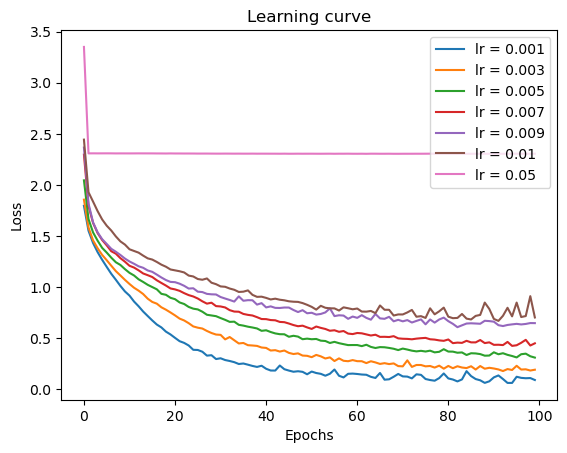

In [11]:
#Neural Network
fig, axes = plt.subplots()

val_error_list = []
te_error_list = []
tr_error_list = []
max_accuracy_index = 0
max_accuracy = 0
best_lr_test_accuracy = 0
i = 0
#different hyper parameters
lr_list = [0.001,0.003,0.005,0.007,0.009,0.01,0.05]
for lr in lr_list:
    clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation = 'relu',n_iter_no_change=100,
                    solver='adam',max_iter=100, learning_rate_init = lr, batch_size=256,random_state=seed).fit(X_tr, y_tr)
    axes.plot(clf.loss_curve_, label = 'lr = '+ str(lr))
    # Accuracy/error
    val_accuracy = clf.score(X_val,y_val)
    val_error = 1 - val_accuracy
    te_accuracy = clf.score(X_te,y_te)
    te_error = 1-te_accuracy
    tr_accuracy = clf.score(X_tr,y_tr)
    tr_error = 1-tr_accuracy

    val_error_list.append(val_error)
    te_error_list.append(te_error)
    tr_error_list.append(tr_error)
    #determine the best learning rate's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_lr_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_lr_test_accuracy = te_accuracy
    i+=1
#end for
axes.set_title("Learning curve")
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.legend(loc='upper right')

best_lr= lr_list[max_accuracy_index]
print("best learning rate is:", best_lr,"accuracy on testing set is ", best_lr_test_accuracy)
#best learning rate is: 0.005 accuracy on testing set is  0.5036
#takes 2 hrs to run

In [12]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation = 'relu',n_iter_no_change=100,
                    solver='adam',max_iter=100, learning_rate_init = best_lr, batch_size=256,random_state=seed).fit(X_tr, y_tr)

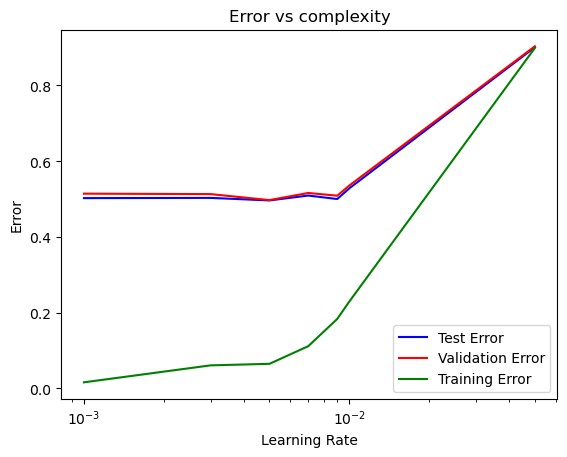

In [13]:
fig, axes = plt.subplots()
#Error vs complexity tradeoffs
axes.semilogx(lr_list, te_error_list, color='blue',  label='Test Error')
axes.semilogx(lr_list, val_error_list, color='red',  label='Validation Error')
axes.semilogx(lr_list, tr_error_list, color='green',  label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Learning Rate')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

In [14]:
#roc_auc_scores for testing set and classfication report
y_te_scores = clf.predict_proba(X_te)
print('Testing set roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))
print(classification_report(y_te, clf.predict(X_te)))

Testing set roc_auc_score: 0.84886
              precision    recall  f1-score   support

           0       0.55      0.61      0.58       986
           1       0.65      0.57      0.60      1018
           2       0.38      0.40      0.39      1005
           3       0.34      0.37      0.36      1023
           4       0.40      0.44      0.42      1004
           5       0.44      0.35      0.39      1024
           6       0.57      0.52      0.55      1006
           7       0.57      0.56      0.57       951
           8       0.63      0.65      0.64       992
           9       0.54      0.57      0.55       991

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.50     10000
weighted avg       0.51      0.50      0.50     10000



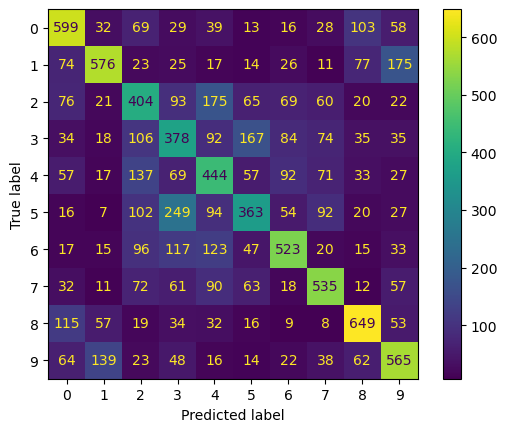

In [15]:
#Confusion Matrix
y_te_pred = clf.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

In [30]:
#Prediction speed Neural Network
clf.predict(X_tr)
#40000 datapoints takes 1.1s = 1100ms
#speed = 0.0275 ms/datapoint

array([4, 0, 1, ..., 6, 2, 1], dtype=uint8)

4.Decision tree

In [16]:
#Decision Tree
val_error_list = []
te_error_list = []
tr_error_list = []
max_accuracy_index = 0
max_accuracy = 0
best_depth_test_accuracy = 0
i = 0
#different hyper parameters
depth_list = [3,4,5,6,7,8,9,10,11,12,13,14,15]
for d in depth_list:
    dtc = DecisionTreeClassifier(max_depth = d,random_state=seed).fit(X_tr, y_tr)
    # Accuracy/error
    val_accuracy = dtc.score(X_val,y_val)
    val_error = 1 - val_accuracy
    te_accuracy = dtc.score(X_te,y_te)
    te_error = 1-te_accuracy
    tr_accuracy = dtc.score(X_tr,y_tr)
    tr_error = 1-tr_accuracy

    val_error_list.append(val_error)
    te_error_list.append(te_error)
    tr_error_list.append(tr_error)
    #determine the best depth's index 
    if i == 0:
        max_accuracy = val_accuracy
        best_depth_test_accuracy = te_accuracy
    else:
        if(max_accuracy<val_accuracy):
            max_accuracy = val_accuracy
            max_accuracy_index = i
            best_depth_test_accuracy = te_accuracy
    i+=1
#end for

best_depth = depth_list[max_accuracy_index]
print("best depth is:", best_depth,"accuracy on testing set is ", best_depth_test_accuracy)
#best depth is: 10 accuracy on testing set is  0.2958

best depth is: 10 accuracy on testing set is  0.2958


In [17]:
dtc = DecisionTreeClassifier(max_depth = best_depth,random_state=seed).fit(X_tr, y_tr)

[Text(0.4990129116766467, 0.9545454545454546, 'X[80] <= 0.235\ngini = 0.9\nsamples = 40000\nvalue = [4017, 3917, 3990, 4028, 4045, 3918, 3998, 4042, 4003\n4042]'),
 Text(0.24726796407185628, 0.8636363636363636, 'X[1400] <= 0.528\ngini = 0.886\nsamples = 22810\nvalue = [1112, 2155, 2761, 2832, 3244, 3035, 3271, 2208, 1064\n1128]'),
 Text(0.12326908682634731, 0.7727272727272727, 'X[2473] <= -0.922\ngini = 0.876\nsamples = 17066\nvalue = [628, 1214, 2310, 2168, 2865, 2011, 2878, 1631, 579\n782]'),
 Text(0.05858907185628742, 0.6818181818181818, 'X[2554] <= -1.274\ngini = 0.88\nsamples = 3408\nvalue = [121, 554, 347, 520, 247, 320, 574, 229, 169, 327]'),
 Text(0.028854790419161676, 0.5909090909090909, 'X[1599] <= 0.724\ngini = 0.859\nsamples = 1128\nvalue = [43, 310, 91, 131, 61, 82, 124, 65, 80, 141]'),
 Text(0.016841317365269462, 0.5, 'X[2591] <= -1.029\ngini = 0.875\nsamples = 928\nvalue = [37, 209, 89, 121, 58, 76, 107, 60, 63, 108]'),
 Text(0.009431137724550898, 0.4090909090909091, 'X[

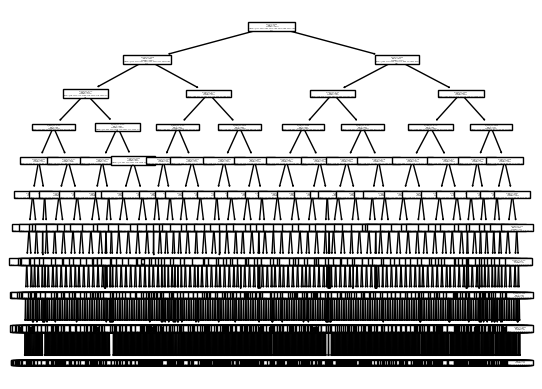

In [20]:
#plot tree for visulization
plot_tree(dtc)

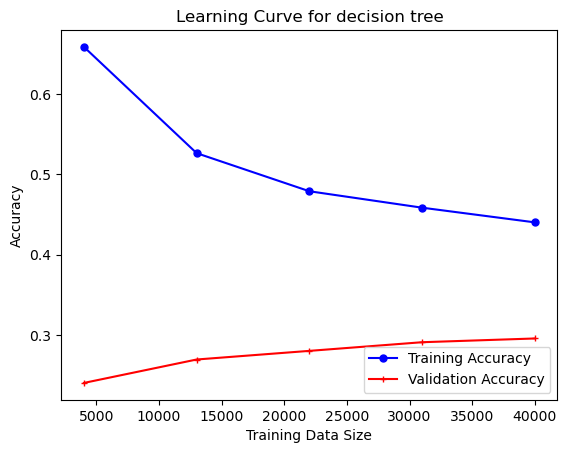

In [21]:
fig, axes = plt.subplots()
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(estimator= dtc, X=X_tr_lc, y=y_tr_lc,n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
axes.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
axes.plot(train_sizes, test_mean, color='red', marker='+', markersize=5, label='Validation Accuracy')
axes.set_title('Learning Curve for decision tree')
axes.set_xlabel('Training Data Size')
axes.set_ylabel('Accuracy')
axes.legend(loc='lower right')

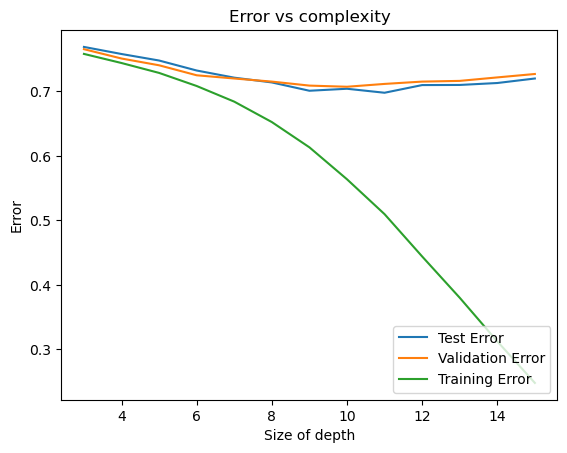

In [22]:
fig, axes = plt.subplots()
#Error vs complexity tradeoffs
axes.plot(depth_list, te_error_list,  label='Test Error')
axes.plot(depth_list, val_error_list, label='Validation Error')
axes.plot(depth_list, tr_error_list,  label='Training Error')
axes.set_title('Error vs complexity')
axes.set_xlabel('Size of depth')
axes.set_ylabel('Error')
axes.legend(loc='lower right')

In [18]:
#roc_auc_scores for testing set and classfication report
y_te_scores = dtc.predict_proba(X_te)
print('Testing set roc_auc_score: %.5f'% roc_auc_score(y_te,y_te_scores, average='macro',multi_class='ovr'))
print(classification_report(y_te, dtc.predict(X_te)))

Testing set roc_auc_score: 0.70837
              precision    recall  f1-score   support

           0       0.33      0.45      0.38       986
           1       0.35      0.26      0.30      1018
           2       0.20      0.15      0.17      1005
           3       0.20      0.19      0.20      1023
           4       0.23      0.30      0.26      1004
           5       0.33      0.19      0.24      1024
           6       0.28      0.41      0.33      1006
           7       0.31      0.27      0.29       951
           8       0.40      0.41      0.41       992
           9       0.32      0.35      0.34       991

    accuracy                           0.30     10000
   macro avg       0.30      0.30      0.29     10000
weighted avg       0.30      0.30      0.29     10000



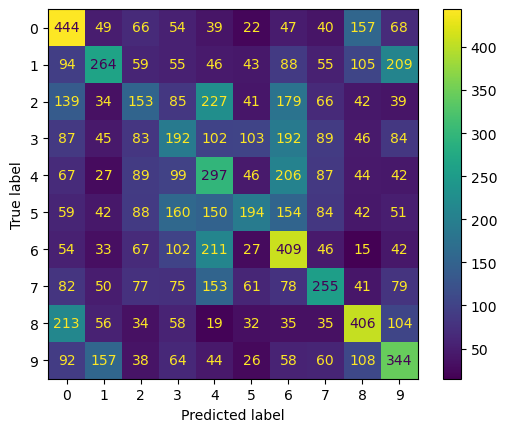

In [19]:
#Confusion Matrix
y_te_pred = dtc.predict(X_te)
sklearn_cm = confusion_matrix(y_te, y_te_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = sklearn_cm)
sklearn_disp.plot()

In [31]:
#Prediction speed decision tree
dtc.predict(X_tr)
#40000 datapoints takes 0.5s = 500ms
#speed = 0.0125ms/datapoint

array([7, 8, 1, ..., 6, 4, 4], dtype=uint8)